In [2]:
#-*- coding:utf-8 -*-
import numpy as np
from scipy.io import loadmat, savemat
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Flatten, Reshape, Dropout, SimpleRNN, LSTM
from keras.losses import categorical_crossentropy
from keras import regularizers
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import Sequence, to_categorical, plot_model
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
import os
from lzy_utils import readdata, get_sub_sequences
from sklearn import preprocessing

C:\Users\Zed_Luz\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#%% Import data and save as dict and list
DatasetPath = r'C:\Users\Zed_Luz\OneDrive - 南方科技大学\BigScaleFiles\1-datasets for bilateral lower limb neuromechanical signals\2-Data'
#OnlineDatapath = r'C:\Users\Zed_Luz\OneDrive - 南方科技大学\BigScaleFiles\1-datasets for bilateral lower limb neuromechanical signals\2-Data\AB185\Processed\AB185_Circuit_001_post.csv'
OnlineDatapath = dict()
IfMaxAbsPreprocess = False
Subjects = []# ['AB185', 'AB186',...]
for (dirpath, dirnames, filenames) in os.walk(DatasetPath):
    Subjects.extend(dirnames)
    break
DataType = [] # ['Features', 'MVC', 'Processed', 'Raw']
for (dirpath, dirnames, filenames) in os.walk(os.path.join(DatasetPath,Subjects[0])):
    DataType.extend(dirnames)
    break
DataFileName = [] # ['Features', 'MVC', 'Processed', 'Raw']
for (dirpath, dirnames, filenames) in os.walk(os.path.join(DatasetPath,Subjects[0],DataType[2])):
    DataFileName.extend(filenames)
    break
data1 = os.path.join(DatasetPath,Subjects[0],DataType[2], DataFileName[0])
data2 = os.path.join(DatasetPath,Subjects[0],DataType[2], DataFileName[2])
array_data1, dict_data1, rowcount1, colcount1, categories1, label_prep1 = readdata(data1)
array_data2, dict_data2, rowcount2, colcount2, categories2, label_prep2 = readdata(data2)
Train_data = array_data1
Val_data = array_data2

In [4]:
#%%
if IfMaxAbsPreprocess:
    max_abs_scaler = preprocessing.MaxAbsScaler()
    Train_data = max_abs_scaler.fit_transform(Train_data)
    Val_data = max_abs_scaler.fit_transform(Val_data)
#Minmax
Min_max_scaller = preprocessing.MinMaxScaler()
Train_data = Min_max_scaller.fit_transform(Train_data)
Val_data = Min_max_scaller.fit_transform(Val_data)

In [5]:
#%% Select specific channels of data 
labelcategories = ['Sitting','Level Ground Walking','Ramp Ascent','Ramp Descent','Stair Ascent','Stair Descent',
                       'Standing']
print(len(categories1),'All of Data types:',categories1)
selectedchannels = ['Right_Shank_Ax', 'Right_Shank_Ay', 'Right_Shank_Az', 'Right_Shank_Gy', 
                    'Right_Shank_Gz', 'Right_Shank_Gx', 'Right_Thigh_Ax', 'Right_Thigh_Ay', 
                    'Right_Thigh_Az', 'Right_Thigh_Gy', 'Right_Thigh_Gz', 'Right_Thigh_Gx', 
                    'Left_Shank_Ax', 'Left_Shank_Ay', 'Left_Shank_Az', 'Left_Shank_Gy', 
                    'Left_Shank_Gz', 'Left_Shank_Gx', 'Left_Thigh_Ax', 'Left_Thigh_Ay', 
                    'Left_Thigh_Az', 'Left_Thigh_Gy', 'Left_Thigh_Gz', 'Left_Thigh_Gx', 
                    'Waist_Ax', 'Waist_Ay', 'Waist_Az', 'Waist_Gy', 'Waist_Gz', 'Waist_Gx',
                    'Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 
                    'Right_Ankle_Velocity', 'Right_Knee_Velocity', 
                    'Left_Ankle_Velocity', 'Left_Knee_Velocity']
# selectedchannels = ['Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 
#                     'Right_Ankle_Velocity', 'Right_Knee_Velocity', 
#                     'Left_Ankle_Velocity', 'Left_Knee_Velocity']
selectedindex = [categories1.index(selectedchannels[i]) 
                    for i in range(len(selectedchannels))]
selectedchannelsNum = len(selectedchannels)
selecteddatain_train = Train_data[:,selectedindex]
selecteddatain_val = Val_data[:,selectedindex]
label_train = dict_data1['Mode']
label_train_prep = to_categorical(label_train)
label_val = dict_data2['Mode']
label_val_prep = to_categorical(label_val)
exp_dur_train = rowcount1/500 # sample rate: 500Hz
exp_dur_val = rowcount2/500 # sample rate: 500Hz
nfeat = selectedchannelsNum
t_train = np.linspace(0, exp_dur_train, rowcount1)
t_val = np.linspace(0, exp_dur_val, rowcount2)

61 All of Data types: ['Right_Shank_Ax', 'Right_Shank_Ay', 'Right_Shank_Az', 'Right_Shank_Gy', 'Right_Shank_Gz', 'Right_Shank_Gx', 'Right_Thigh_Ax', 'Right_Thigh_Ay', 'Right_Thigh_Az', 'Right_Thigh_Gy', 'Right_Thigh_Gz', 'Right_Thigh_Gx', 'Left_Shank_Ax', 'Left_Shank_Ay', 'Left_Shank_Az', 'Left_Shank_Gy', 'Left_Shank_Gz', 'Left_Shank_Gx', 'Left_Thigh_Ax', 'Left_Thigh_Ay', 'Left_Thigh_Az', 'Left_Thigh_Gy', 'Left_Thigh_Gz', 'Left_Thigh_Gx', 'Waist_Ax', 'Waist_Ay', 'Waist_Az', 'Waist_Gy', 'Waist_Gz', 'Waist_Gx', 'Right_TA', 'Right_MG', 'Right_SOL', 'Right_BF', 'Right_ST', 'Right_VL', 'Right_RF', 'Left_TA', 'Left_MG', 'Left_SOL', 'Left_BF', 'Left_ST', 'Left_VL', 'Left_RF', 'Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 'Right_Ankle_Velocity', 'Right_Knee_Velocity', 'Left_Ankle_Velocity', 'Left_Knee_Velocity', 'Mode', 'Right_Heel_Contact', 'Right_Heel_Contact_Trigger', 'Right_Toe_Off', 'Right_Toe_Off_Trigger', 'Left_Heel_Contact', 'Left_Heel_Contact_Trigger', 'Left_Toe_Off', 'Left_

Illustate  38 channels of data...


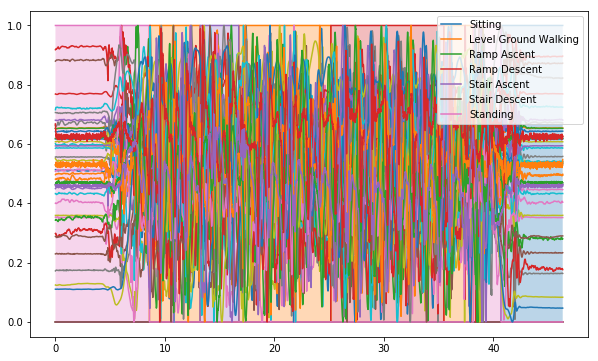

In [6]:
#%% Display train data
print('Illustate ', selectedchannelsNum, 'channels of data...')
plt.figure(figsize=(10, 6))
cm = plt.get_cmap(name='gist_rainbow')
for i in range(7):
        plt.plot(t_train, label_prep1[:,i]*selecteddatain_train.max(), label=labelcategories[i])
        plt.set_cmap(cm)
        plt.fill_between(t_train, label_prep1[:,i]*selecteddatain_train.min(), 
                         label_prep1[:,i]*selecteddatain_train.max(), alpha=0.3)
plt.plot(t_train, selecteddatain_train)
plt.legend()
plt.show()

## Win_size=200, Step_size=10

In [14]:
win_size = 200
step_leng = 10
data_seq_train_Oshape, label_seq_train = get_sub_sequences(selecteddatain_train, 
                                                    label_train_prep, window_size=win_size, step_size=step_leng)
data_seq_train = np.reshape(data_seq_train_Oshape, newshape=(data_seq_train_Oshape.shape[0], data_seq_train_Oshape.shape[1], 
                                                      data_seq_train_Oshape.shape[2], 1))
data_seq_val_Oshape, label_seq_val = get_sub_sequences(selecteddatain_val, label_val_prep, window_size=win_size,
                                                step_size=step_leng)
data_seq_val = np.reshape(data_seq_val_Oshape, newshape=(data_seq_val_Oshape.shape[0], data_seq_val_Oshape.shape[1], 
                                                  data_seq_val_Oshape.shape[2], 1))

In [15]:
data_seq_train_Oshape.shape

(2316, 200, 38)

In [16]:
label_seq_train.shape

(2316, 7)

In [17]:
data_seq_train_Oshape.shape[-2:]

(200, 38)

In [18]:
model_rnn = Sequential()
model_rnn.add(LSTM(24, input_shape=(None,data_seq_train_Oshape.shape[2]),return_sequences=True))
model_rnn.add(LSTM(12,return_sequences=False))
model_rnn.add(Dense(label_seq_train.shape[1],activation='softmax'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 24)          6048      
_________________________________________________________________
lstm_4 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 91        
Total params: 7,915
Trainable params: 7,915
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model_rnn.fit(data_seq_train_Oshape,label_seq_train,epochs=10, validation_data=(data_seq_val_Oshape,label_seq_val))

Train on 2316 samples, validate on 2262 samples
Epoch 1/10
2316/2316 [==============================] - 17s 7ms/step - loss: 0.1039 - acc: 0.4072 - val_loss: 0.1010 - val_acc: 0.3833
Epoch 2/10
2316/2316 [==============================] - 19s 8ms/step - loss: 0.0887 - acc: 0.5458 - val_loss: 0.1095 - val_acc: 0.3046
Epoch 3/10
2316/2316 [==============================] - 17s 8ms/step - loss: 0.0877 - acc: 0.5130 - val_loss: 0.0955 - val_acc: 0.4094
Epoch 4/10
2316/2316 [==============================] - 17s 7ms/step - loss: 0.0855 - acc: 0.5168 - val_loss: 0.0975 - val_acc: 0.3780
Epoch 5/10
2316/2316 [==============================] - 16s 7ms/step - loss: 0.1026 - acc: 0.3605 - val_loss: 0.1010 - val_acc: 0.3705
Epoch 6/10
2316/2316 [==============================] - 16s 7ms/step - loss: 0.0800 - acc: 0.5531 - val_loss: 0.1015 - val_acc: 0.3590
Epoch 7/10
2316/2316 [==============================] - 16s 7ms/step - loss: 0.0849 - acc: 0.4970 - val_loss: 0.0988 - val_acc: 0.3727
Epoch 8

In [20]:
results = model_rnn.predict(data_seq_val_Oshape)
results.shape

(2262, 7)

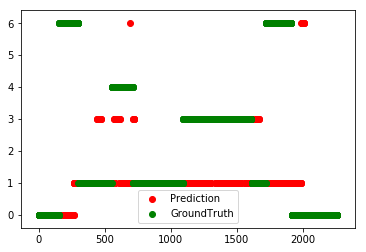

In [13]:
plt.scatter(range(len(data_seq_val)),np.argmax(results,axis=-1),c='r',label='Prediction')
plt.scatter(range(len(data_seq_val)),np.argmax(label_seq_val,axis=-1),c='g',label='GroundTruth')
plt.legend()
plt.ylabel('Modes')
plt.show()

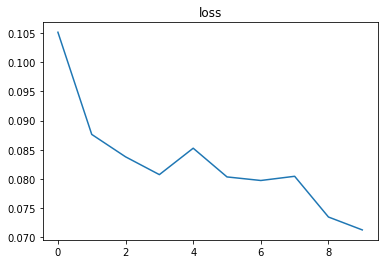

In [14]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

## Win_size=400, Step_size=10

In [15]:
win_size = 200
step_leng = 10
data_seq_train_Oshape, label_seq_train = get_sub_sequences(selecteddatain_train, 
                                                    label_train_prep, window_size=win_size, step_size=step_leng)
data_seq_train = np.reshape(data_seq_train_Oshape, newshape=(data_seq_train_Oshape.shape[0], data_seq_train_Oshape.shape[1], 
                                                      data_seq_train_Oshape.shape[2], 1))
data_seq_val_Oshape, label_seq_val = get_sub_sequences(selecteddatain_val, label_val_prep, window_size=win_size,
                                                step_size=step_leng)
data_seq_val = np.reshape(data_seq_val_Oshape, newshape=(data_seq_val_Oshape.shape[0], data_seq_val_Oshape.shape[1], 
                                                  data_seq_val_Oshape.shape[2], 1))

In [16]:
model_rnn = Sequential()
model_rnn.add(LSTM(24, input_shape=(None,data_seq_train_Oshape.shape[2]),
                   return_sequences=True))
model_rnn.add(LSTM(12,return_sequences=False))
model_rnn.add(Dense(label_seq_train.shape[1],activation='softmax'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 24)          6048      
_________________________________________________________________
lstm_4 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 91        
Total params: 7,915
Trainable params: 7,915
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model_rnn.fit(data_seq_train_Oshape,label_seq_train,epochs=10, validation_data=(data_seq_val_Oshape,label_seq_val))

Train on 2316 samples, validate on 2262 samples
Epoch 1/10
2316/2316 [==============================] - 15s 7ms/step - loss: 0.1050 - acc: 0.3752 - val_loss: 0.1011 - val_acc: 0.4222
Epoch 2/10
2316/2316 [==============================] - 17s 7ms/step - loss: 0.0921 - acc: 0.4655 - val_loss: 0.0978 - val_acc: 0.3634
Epoch 3/10
2316/2316 [==============================] - 19s 8ms/step - loss: 0.0877 - acc: 0.4732 - val_loss: 0.0938 - val_acc: 0.3705
Epoch 4/10
2316/2316 [==============================] - 23s 10ms/step - loss: 0.0853 - acc: 0.5043 - val_loss: 0.0972 - val_acc: 0.3771
Epoch 5/10
2316/2316 [==============================] - 19s 8ms/step - loss: 0.0825 - acc: 0.5173 - val_loss: 0.0934 - val_acc: 0.3630
Epoch 6/10
2316/2316 [==============================] - 20s 9ms/step - loss: 0.0806 - acc: 0.5419 - val_loss: 0.0900 - val_acc: 0.4164
Epoch 7/10
2316/2316 [==============================] - 16s 7ms/step - loss: 0.0784 - acc: 0.5669 - val_loss: 0.0876 - val_acc: 0.5407
Epoch 

In [18]:
results = model_rnn.predict(data_seq_val_Oshape)
results.shape

(2262, 7)

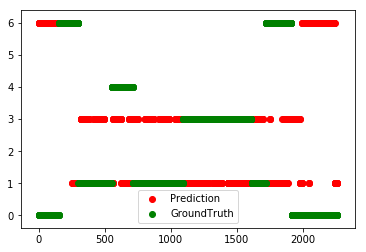

In [19]:
plt.scatter(range(len(data_seq_val)),np.argmax(results,axis=-1),c='r',label='Prediction')
plt.scatter(range(len(data_seq_val)),np.argmax(label_seq_val,axis=-1),c='g',label='GroundTruth')
plt.legend()
plt.ylabel('Modes')
plt.show()

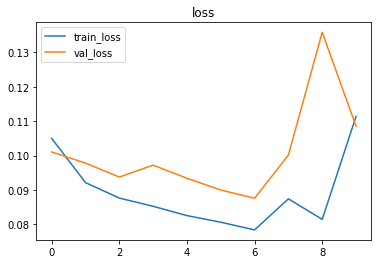

In [23]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

## Win_size=50, Step_size=5

In [7]:
win_size = 50
step_leng = 5
data_seq_train_Oshape, label_seq_train = get_sub_sequences(selecteddatain_train, 
                                                    label_train_prep, window_size=win_size, step_size=step_leng)
data_seq_train = np.reshape(data_seq_train_Oshape, newshape=(data_seq_train_Oshape.shape[0], data_seq_train_Oshape.shape[1], 
                                                      data_seq_train_Oshape.shape[2], 1))
data_seq_val_Oshape, label_seq_val = get_sub_sequences(selecteddatain_val, label_val_prep, window_size=win_size,
                                                step_size=step_leng)
data_seq_val = np.reshape(data_seq_val_Oshape, newshape=(data_seq_val_Oshape.shape[0], data_seq_val_Oshape.shape[1], 
                                                  data_seq_val_Oshape.shape[2], 1))

In [8]:
model_rnn = Sequential()
model_rnn.add(LSTM(24, input_shape=(None,data_seq_train_Oshape.shape[2]),
                   return_sequences=True))
model_rnn.add(LSTM(12,return_sequences=False))
model_rnn.add(Dense(label_seq_train.shape[1],activation='softmax'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 24)          6048      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 91        
Total params: 7,915
Trainable params: 7,915
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model_rnn.fit(data_seq_train_Oshape,label_seq_train,epochs=100, validation_data=(data_seq_val_Oshape,label_seq_val))

Train on 4632 samples, validate on 4524 samples
Epoch 1/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.1013 - acc: 0.4393 - val_loss: 0.1055 - val_acc: 0.3176
Epoch 2/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0812 - acc: 0.5574 - val_loss: 0.1013 - val_acc: 0.3705
Epoch 3/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0738 - acc: 0.6220 - val_loss: 0.0843 - val_acc: 0.6149
Epoch 4/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0670 - acc: 0.6442 - val_loss: 0.0830 - val_acc: 0.4980
Epoch 5/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0669 - acc: 0.6436 - val_loss: 0.0917 - val_acc: 0.5000
Epoch 6/100
4632/4632 [==============================] - 7s 2ms/step - loss: 0.0539 - acc: 0.7392 - val_loss: 0.0742 - val_acc: 0.6424
Epoch 7/100
4632/4632 [==============================] - 7s 2ms/step - loss: 0.0573 - acc: 0.7094 - val_loss: 0.0891 - val_acc: 0.5210
Epoch 8

Epoch 61/100
4632/4632 [==============================] - 7s 2ms/step - loss: 0.0197 - acc: 0.9212 - val_loss: 0.0900 - val_acc: 0.6642
Epoch 62/100
4632/4632 [==============================] - 7s 2ms/step - loss: 0.0361 - acc: 0.8657 - val_loss: 0.0812 - val_acc: 0.6627
Epoch 63/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0228 - acc: 0.8942 - val_loss: 0.0858 - val_acc: 0.6441
Epoch 64/100
4632/4632 [==============================] - 9s 2ms/step - loss: 0.0085 - acc: 0.9629 - val_loss: 0.0599 - val_acc: 0.7339
Epoch 65/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0125 - acc: 0.9473 - val_loss: 0.0618 - val_acc: 0.7511
Epoch 66/100
4632/4632 [==============================] - 9s 2ms/step - loss: 0.0019 - acc: 0.9909 - val_loss: 0.0610 - val_acc: 0.7606
Epoch 67/100
4632/4632 [==============================] - 8s 2ms/step - loss: 0.0022 - acc: 0.9886 - val_loss: 0.0598 - val_acc: 0.7436
Epoch 68/100
4632/4632 [========================

In [10]:
results = model_rnn.predict(data_seq_val_Oshape)
results.shape

(4524, 7)

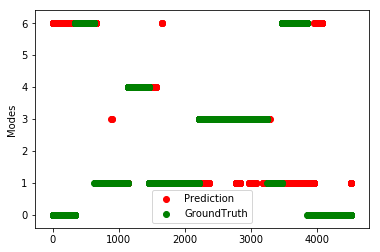

In [11]:
plt.scatter(range(len(data_seq_val)),np.argmax(results,axis=-1),c='r',label='Prediction')
plt.scatter(range(len(data_seq_val)),np.argmax(label_seq_val,axis=-1),c='g',label='GroundTruth')
plt.legend()
plt.ylabel('Modes')
plt.show()

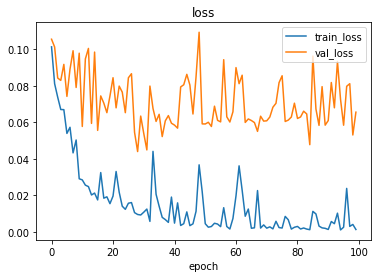

In [13]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss')
plt.legend()
plt.xlabel('epoch')
plt.show()